In [94]:
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.datasets import load_iris
#from statistics import mean
# import random
#from numpy import linalg as LA
#from sklearn import decomposition
#%matplotlib inline

# Excercise 1. Backpropagation
Add Backpropagation to your MLP and train the model on the ZIP-Dataset.

In [34]:
class MLP:
    def __init__(self, threshold, depth, layer_width, gamma=0.01, iterations=1000):
        """
        This constructor sets random network weights and checks if the input depth matches the provided layers.
        """
        self.gamma = gamma # learning rate
        self.iterations = iterations
        self.threshold = threshold
        if depth < 2:
            raise Exception("Depth needs to be at least 2 (one hidden and one output layer)!!")  
        self.depth = depth
        if not len(layer_width) == (depth + 1):
            raise Exception("'layer_width' needs to be of length 'depth' + 1")  
        self.layer_width = layer_width
        self.network_weights = []
        #self.network_biases = []
        width_prev = self.layer_width[0]
        for width in self.layer_width[1:]:
            #added +1 to incorporate bias into weight
            self.network_weights.append(np.random.randn(width_prev+1, width)* np.sqrt(1. / width_prev+1))
            #self.network_biases.append(np.zeros((1, width)))
            width_prev = width
    
    def heaviside(self, Z):
        """This Function is a tiny implementation of the heaviside step function."""
        return (Z > 0).astype(int)
    
    def heaviside_derivative(self, Z):
        """This Function returns the evaluated derivative of the heaviside step function."""
        return np.where(Z == 0, 0, np.inf)
    
    def sigmoid(self, Z):
        return 1./(1.+np.exp(-Z))
    
    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1-self.sigmoid(Z))
    
    def error_function(self, y_i, t_i):
        return 0.5 * np.power(y_i - t_i, 2)
    
    def error_function_derivative(self, y_i, t_i):
        return y_i - t_i
    
    def forward_pass(self, X, f_activation, deriv_activation):
        """This Function passes the input X through all weights and returns the prediction vector."""
        self.activated_X_i = []
        self.derivated_X_i = []
        X_i = X.copy()
        for i in range(self.depth):
            X_i = np.hstack((X_i, np.ones((X_i.shape[0],1))))
            z_i = X_i @ self.network_weights[i]
            X_i = f_activation(z_i)
            deriv_X_i = deriv_activation(z_i)
            self.activated_X_i.append(X_i)
            self.derivated_X_i.append(np.diag(np.mean(deriv_X_i, axis=0)))
        return X_i
    
    def backward_pass_updates(self, X, deriv_error):
        """This Function passes backwards through the network for backpropagation."""
        delta = deriv_error @ self.derivated_X_i[self.depth-1]
        o_hat = self.activated_X_i[self.depth-2]
        o_hat = np.hstack((o_hat, np.ones((o_hat.shape[0],1))))
        d_W_i = - self.gamma * o_hat.T @ delta
        self.network_weights[self.depth-1] += d_W_i
        for i in range(self.depth-2, -1, -1):
            delta = delta @ self.network_weights[i+1][:-1,].T @ self.derivated_X_i[i]
            if i == 0:
                o_hat = np.hstack((X, np.ones((X.shape[0],1))))
                d_W_i = - self.gamma * o_hat.T @ delta
            else:
                o_hat = self.activated_X_i[i-1]
                o_hat = np.hstack((o_hat, np.ones((o_hat.shape[0],1))))
                d_W_i = - self.gamma * o_hat.T @ delta
            self.network_weights[i] += d_W_i
    
    def train(self, X_train, y_train):
        y_true = y_train.reshape((y_train.shape[0],1))
        for i in range(self.iterations):
            y_i = self.forward_pass(X_train, self.sigmoid, self.sigmoid_derivative)
            error = self.error_function(y_i, y_true)
            deriv_error = self.error_function_derivative(y_i, y_true)
            self.backward_pass_updates(X_train, deriv_error)
    
    def predict(self, X, cutoff=0.5):
        """This function passes the input X to the iteration function."""
        #X_i = np.hstack((X, np.ones((X.shape[0],1))))
        return ((self.forward_pass(X, self.sigmoid, self.sigmoid_derivative) > cutoff).astype(int)).ravel()
    
    def accuracy(self, labels, predictions):
        """This function calculates the binary class accuracy for given true/predicted labels."""
        return np.mean(labels == predictions)

#### Load the Zip Dataset

In [3]:
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train_zip, y_train_zip = training_data[:,1:-1], training_data[:,0]
X_test_zip, y_test_zip = test_data[:,1:], test_data[:,0]

X_train_zip = X_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]
y_train_zip = y_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]

X_test_zip = X_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]
y_test_zip = y_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]

In [35]:
mlp_network = MLP(threshold=0.01, depth=3, layer_width=[X_train_zip.shape[1], 100, 10, 1])

In [36]:
for weight_v in mlp_network.network_weights:
    print(weight_v.shape)
# print(mlp_network.network_biases[0].shape) <- moved into weight matrix
# print(mlp_network.network_biases[1].shape)

(257, 100)
(101, 10)
(11, 1)


In [37]:
mlp_network.train(X_train_zip, y_train_zip)

In [38]:
y_pred_mlp = mlp_network.predict(X_test_zip)

In [39]:
mlp_network.accuracy(y_test_zip, y_pred_mlp)

0.9903691813804173

In [40]:
np.unique(y_pred_mlp, return_counts=True)

(array([0, 1]), array([359, 264], dtype=int64))

In [41]:
np.unique(y_test_zip, return_counts=True)

(array([0., 1.]), array([359, 264], dtype=int64))

#### Get a mean accuracy over multiple runs

In [42]:
acc_list_mlp = []
n_runs = 10
for i in range(n_runs):
    mlp_network = MLP(threshold=0.01, depth=3, layer_width=[X_train_zip.shape[1], 100, 10, 1], iterations=100)
    mlp_network.train(X_train_zip, y_train_zip)
    y_pred_loop = mlp_network.predict(X_test_zip)
    acc_list_mlp.append(mlp_network.accuracy(y_test_zip, y_pred_loop))
print("Mean Acc over", n_runs, "runs, with random weights is:", np.mean(acc_list_mlp))

Mean Acc over 10 runs, with random weights is: 0.9808988764044944


### Result:
Works nicely :)

## (a) Optimize width (the number of neurons in a hidden layer; it is usually the same for all of them) and depth of the network. Try to find a setting that trains in a reasonable time. Plot the loss.

In [80]:
def cross_validation(X_train, y_train, y_test, widths, depths, nr_folds = 5):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    fold_indices_list = np.array_split(indices, nr_folds)
    
    depth_accs = []
    for depth in depths:
        width_accs = []
        for width in widths:
            print("Cross Val depth:",depth,"width:",width)
            cval_acc_mlp = []
            for fold_counter, val_indices in enumerate(fold_indices_list):
                X_val = X_train[val_indices]
                y_val = y_train[val_indices]
                X_training = np.delete(X_train, val_indices, 0)
                y_training = np.delete(y_train, val_indices, 0)
                width_list = [X_train_zip.shape[1]] + [width] * (depth-1) + [1]
                cross_val_mlp = MLP(threshold=0.001, depth=depth, layer_width=width_list, iterations=500)
                cross_val_mlp.train(X_training, y_training)
                y_pred_cv = mlp_network.predict(X_val)
                cval_acc_mlp.append(mlp_network.accuracy(y_val, y_pred_cv))
            width_accs.append(cval_acc_mlp)
        depth_accs.append(width_accs)
    return(np.array(depth_accs))

In [87]:
cv_widths = [2, 5, 10, 20]
cv_depths = [2, 3, 5, 10]
cv_accuracies = cross_validation(X_train_zip, y_train_zip, y_test_zip, cv_widths, cv_depths, nr_folds = 5)

Cross Val depth: 2 width: 2
Cross Val depth: 2 width: 5
Cross Val depth: 2 width: 10
Cross Val depth: 2 width: 20
Cross Val depth: 3 width: 2


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Cross Val depth: 3 width: 5
Cross Val depth: 3 width: 10
Cross Val depth: 3 width: 20
Cross Val depth: 5 width: 2
Cross Val depth: 5 width: 5
Cross Val depth: 5 width: 10
Cross Val depth: 5 width: 20
Cross Val depth: 10 width: 2
Cross Val depth: 10 width: 5
Cross Val depth: 10 width: 10
Cross Val depth: 10 width: 20


In [88]:
cv_accuracies

array([[0.97226548, 0.97226548, 0.97226548, 0.97226548],
       [0.97226548, 0.97226548, 0.97226548, 0.97226548],
       [0.97226548, 0.97226548, 0.97226548, 0.97226548],
       [0.97226548, 0.97226548, 0.97226548, 0.97226548]])

## (b) Show some digits that are classified incorrectly.

In [86]:
mlp_network_refined = MLP(threshold=0.01, depth=3, layer_width=[X_train_zip.shape[1], 100, 10, 1])

for weight_v in mlp_network_refined.network_weights:
    print(weight_v.shape)

mlp_network_refined.train(X_train_zip, y_train_zip)

y_pred_refined = mlp_network_refined.predict(X_test_zip)

mlp_network_refined.accuracy(y_test_zip, y_pred_refined)

(257, 100)
(101, 10)
(11, 1)


0.9871589085072231

In [95]:
def show_few_numbers(Xi):
    fig = plt.figure(figsize=(10, 6))
    i = 1
    for X in Xi:
        ax = plt.subplot(len(Xi)//10 + 1, 10, i)
        plt.imshow(1-X.reshape((16, 16)), cmap='gray')
        plt.axis('off')
        i += 1

### Show the missclassified numbers:

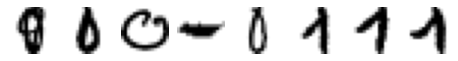

In [96]:
show_few_numbers(X_test_zip[np.where(y_test_zip != y_pred_refined)])

## (c) Plot your first weight layer as a grayscale image.

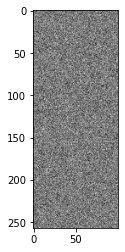

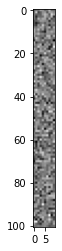

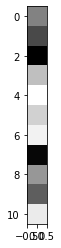

In [101]:
for weight_vector_img in mlp_network_refined.network_weights:
    plt.imshow(weight_vector_img, cmap='gray')
    plt.show()